In [1]:
import sys
sys.path.insert(0, '../')

train: Scanning /home/kevinserrano/GitHub/yolov5/datasets/TRAIN_THERMAL_DATASET_2023_06_2023-08-01/labels/train.cache... 31954 images, 6479 backgrounds, 0 corrupt: 100%|██████████| 31954/31954 00:00
train: WARNING ⚠️ /home/kevinserrano/GitHub/yolov5/datasets/TRAIN_THERMAL_DATASET_2023_06_2023-08-01/images/train/1344267_r.png: 1 duplicate labels removed
train: WARNING ⚠️ /home/kevinserrano/GitHub/yolov5/datasets/TRAIN_THERMAL_DATASET_2023_06_2023-08-01/images/train/1356951_r.png: 1 duplicate labels removed
train: WARNING ⚠️ /home/kevinserrano/GitHub/yolov5/datasets/TRAIN_THERMAL_DATASET_2023_06_2023-08-01/images/train/1381514_l.png: 2 duplicate labels removed
train: WARNING ⚠️ /home/kevinserrano/GitHub/yolov5/datasets/TRAIN_THERMAL_DATASET_2023_06_2023-08-01/images/train/1390422_l.png: 1 duplicate labels removed
train: WARNING ⚠️ /home/kevinserrano/GitHub/yolov5/datasets/TRAIN_THERMAL_DATASET_2023_06_2023-08-01/images/train/20133685_r.png: 2 duplicate labels removed
train: WARNING ⚠️ /h

torch.Size([3, 640, 640]) torch.Size([4, 6]) 512 640 (0.0, 64.0)


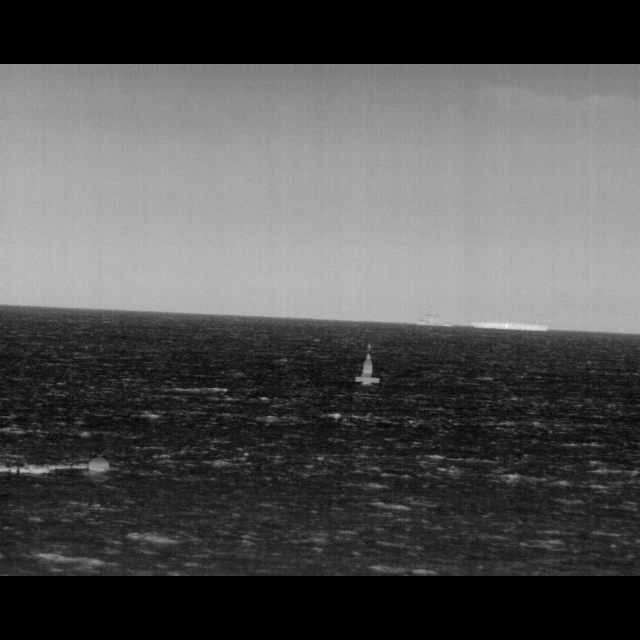

In [2]:
import numpy as np
from PIL import Image
from utils.dataloaders import create_dataloader
from utils.general import check_dataset, colorstr
# (LOGGER, TQDM_BAR_FORMAT, Profile, check_dataset, check_img_size, check_requirements,
#     check_yaml, coco80_to_coco91_class, colorstr, increment_path, non_max_suppression,
#     print_args, scale_boxes, xywh2xyxy, xyxy2xywh)

task = 'train'
dataset_yaml = "../datasets/TRAIN_THERMAL_DATASET_2023_06_2023-08-01/dataset.yaml"
data = check_dataset(dataset_yaml)  # check

dataloader, dataset = create_dataloader(
    data[task], # 
    imgsz=640,
    batch_size=16,
    stride=1,
    single_cls=False,
    pad=0.5,
    rect=False,
    augment=False,
    prefix=colorstr(f'{task}: '))

for img, labels, im_file, ((h0, w0), (_, pad)) in dataset:
    print(img.shape, labels.shape, h0, w0, pad)
    break

Image.fromarray(img[0].numpy()) #.transpose(1,2,0).astype(np.uint8))

In [3]:
import torch
from models.common import DetectMultiBackend
from utils.general import non_max_suppression, xywh2xyxy
from utils.torch_utils import select_device

device = select_device('') # smart selection
weights = '../yolos/yolov5n_T16-8_D2306-v0_9C.pt'
dnn = False
data = None
half = False
conf_thres = 0.25
iou_thres = 0.45
classes = None
agnostic_nms = True
max_det = 100

model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=half)

def preprocess(im):
    im = img.clone()  # avoid inplace modifications
    im = im.to(model.device)
    im = im.half() if model.fp16 else im.float()  # uint8 to fp16/32
    im /= 255  # 0 - 255 to 0.0 - 1.0
    if len(im.shape) == 3:
        im = im[None]  # expand for batch dim
    return im

def inference(im):
    pred = model(im, augment=False, visualize=False)
    return pred

def postprocess(pred):
    pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
    return pred

im = preprocess(img)
pred = inference(im)
print('Before postprocess: ', pred[0].shape)
#pred = postprocess(pred)
#print('After postprocess: ', pred[0].shape)

YOLOv5 🚀 bb9faa7 Python-3.10.11 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)

Fusing layers... 
Model summary: 157 layers, 1771342 parameters, 0 gradients, 4.2 GFLOPs


Before postprocess:  torch.Size([1, 25200, 14])


In [6]:
x = pred[0] # only one image
x = x[x[..., 4] > conf_thres] # confidence threshold
print('After 1st confidence threshold: ', x.shape)
box = xywh2xyxy(x[:, :4])  # center_x, center_y, width, height) to (x1, y1, x2, y2)
x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf
conf, j = x[:, 5:].max(1, keepdim=True)
x = torch.cat((box, conf, j.float()), 1)
x = x[conf.view(-1) > conf_thres]
print('After 2nd confidence threshold: ', x.shape)

After 1st confidence threshold:  torch.Size([48, 14])
After 2nd confidence threshold:  torch.Size([48, 6])


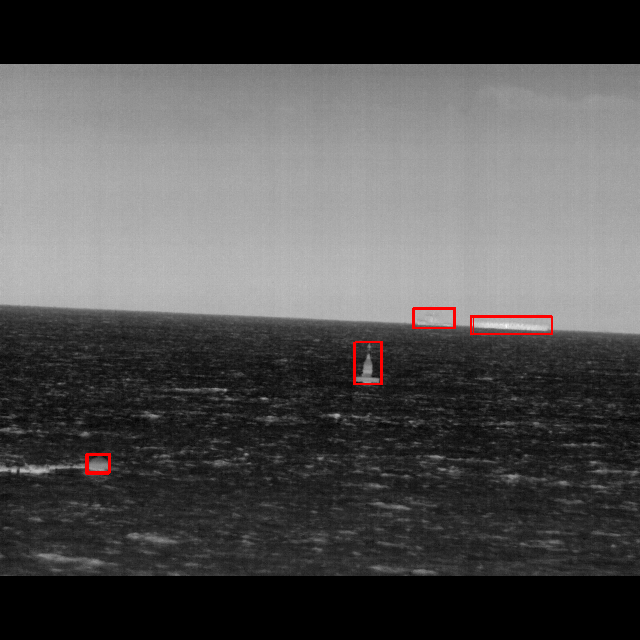

In [7]:
# print boxes over image using PIL
from PIL import ImageDraw
I = Image.fromarray(img[0].numpy()).convert('RGB')
draw = ImageDraw.Draw(I)
for box in x:
    draw.rectangle(list(box[:4]), outline='red', width=1)
I

In [8]:
pred = postprocess(pred)
print('After postprocess: ', pred[0].shape)

After postprocess:  torch.Size([4, 6])


In [9]:
for m in model.model.model:
    print(m.i, m.f, m.type)

0 -1 models.common.Conv
1 -1 models.common.Conv
2 -1 models.common.C3
3 -1 models.common.Conv
4 -1 models.common.C3
5 -1 models.common.Conv
6 -1 models.common.C3
7 -1 models.common.Conv
8 -1 models.common.C3
9 -1 models.common.SPPF
10 -1 models.common.Conv
11 -1 torch.nn.modules.upsampling.Upsample
12 [-1, 6] models.common.Concat
13 -1 models.common.C3
14 -1 models.common.Conv
15 -1 torch.nn.modules.upsampling.Upsample
16 [-1, 4] models.common.Concat
17 -1 models.common.C3
18 -1 models.common.Conv
19 [-1, 14] models.common.Concat
20 -1 models.common.C3
21 -1 models.common.Conv
22 [-1, 10] models.common.Concat
23 -1 models.common.C3
24 [17, 20, 23] models.yolo.Detect


In [12]:
from models.yolo import BaseModel, DetectionModel
from models.common import Classify, DetectMultiBackend

class HorizonModel(BaseModel):

    def __init__(self, model: DetectionModel, 
                 nc_pitch: int = 500, 
                 nc_theta: int = 500, 
                 cutoff: int = 8,
                 mode: str = "classification"):
        super().__init__()
        
        # check if model is an instance of DetectMultiBackend
        if isinstance(model, DetectMultiBackend):
            device = model.device
            model = model.model # unwrap DetectMultiBackend
        else:
            raise TypeError(f"Model must be an instance of {DetectMultiBackend}")

        # Adding classification heads similar to method found in
        # models.yolo.ClassificationModel._from_detection_model

        # get number of input channels for classification heads
        m = model.model[cutoff + 1] # layer after cutoff
        ch = m.conv.in_channels if hasattr(m, 'conv') else m.cv1.conv.in_channels  # ch into module
        
        # define classification heads
        c_pitch = Classify(ch, nc_pitch).to(device)
        c_pitch.i, c_pitch.f, c_pitch.type = 'c_pitch', cutoff, 'models.common.Classify'
        c_theta = Classify(ch, nc_theta).to(device)
        c_theta.i, c_theta.f, c_theta.type = 'c_theta', cutoff, 'models.common.Classify'

        self.model = model.model
        self.stride = model.stride
        self.save = list(set(model.save + [cutoff])) # avoid duplication
        self.nc = model.nc
        self.cutoff = cutoff
        self.mode = mode

        # add classification heads to model
        self.model.add_module(c_pitch.i, c_pitch)
        self.model.add_module(c_theta.i, c_theta)
        
    def _classify_once(self, x):
        x_pitch, x_theta = None, None
        y, dt = [], []  # outputs
        for m in self.model:
            if isinstance(m.i, int) and m.i > self.cutoff:
                continue
            if m.f != -1:  # if not from previous layer
                x = y[m.f] if isinstance(m.f, int) else [x if j == -1 else y[j] for j in m.f]  # from earlier layers
            if m.type == 'models.common.Classify' and 'pitch' in m.i:
                x_pitch = m(x)
            elif m.type == 'models.common.Classify' and 'theta' in m.i:
                x_theta = m(x)
            else: # object detection flow
                x = m(x)  # run
                y.append(x if m.i in self.save else None)  # save output
            
        return (x_pitch, x_theta)
    
    def _detect_once(self, x):
        y, dt = [], []  # outputs
        for m in self.model:
            if m.type == 'models.common.Classify':
                continue
            if m.f != -1:  # if not from previous layer
                x = y[m.f] if isinstance(m.f, int) else [x if j == -1 else y[j] for j in m.f]  # from earlier layers
            x = m(x)  # run
            y.append(x if m.i in self.save else None)  # save output
        return x
    
    def _forward_once(self, x):
        y, dt = [], []  # outputs
        x_pitch, x_theta = None, None
        for m in self.model:
            if m.type == 'models.common.Classify':
                continue
            if m.f != -1:  # if not from previous layer
                x = y[m.f] if isinstance(m.f, int) else [x if j == -1 else y[j] for j in m.f]  # from earlier layers
            x = m(x)  # run
            y.append(x if m.i in self.save else None)  # save output
        return x

    def forward(self, x):
        if self.mode == "detection":
            return self._forward_once(x)
        elif self.mode == "classification":
            return self._classify_once(x)
        else:
            raise NotImplementedError(f"Mode {self.mode} not implemented")

hmodel = HorizonModel(model)
for m in model.model.model:
    print(m.i, m.f, m.type, 'save' if m.i in hmodel.save else '')

0 -1 models.common.Conv 
1 -1 models.common.Conv 
2 -1 models.common.C3 
3 -1 models.common.Conv 
4 -1 models.common.C3 save
5 -1 models.common.Conv 
6 -1 models.common.C3 save
7 -1 models.common.Conv 
8 -1 models.common.C3 save
9 -1 models.common.SPPF 
10 -1 models.common.Conv save
11 -1 torch.nn.modules.upsampling.Upsample 
12 [-1, 6] models.common.Concat 
13 -1 models.common.C3 
14 -1 models.common.Conv save
15 -1 torch.nn.modules.upsampling.Upsample 
16 [-1, 4] models.common.Concat 
17 -1 models.common.C3 save
18 -1 models.common.Conv 
19 [-1, 14] models.common.Concat 
20 -1 models.common.C3 save
21 -1 models.common.Conv 
22 [-1, 10] models.common.Concat 
23 -1 models.common.C3 save
24 [17, 20, 23] models.yolo.Detect 
c_pitch 8 models.common.Classify 
c_theta 8 models.common.Classify 


In [13]:
x_pitch, x_theta = hmodel(im)
print(x_pitch.shape, x_theta.shape)

torch.Size([1, 500]) torch.Size([1, 500])


In [2]:
import numpy as np
import fiftyone as fo
from fiftyone import ViewField as F
from torch.utils.data import DataLoader
import albumentations as A
import cv2

from horizon.dataloaders import HorizonDataset
from horizon.utils import vis_keypoints, points_to_pitch_theta, points_to_slope_intercept

In [5]:
horizon_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.PadIfNeeded(min_height=640, min_width=640, border_mode=cv2.BORDER_CONSTANT),
        A.ShiftScaleRotate(p=1, shift_limit=0, scale_limit=0, rotate_limit=20, border_mode=cv2.BORDER_CONSTANT),
        A.RandomCrop(height=640, width=640),
    ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))


dataset = HorizonDataset(
    dataset=(fo.load_dataset("TRAIN_THERMAL_DATASET_2023_06")
             .match(F("ground_truth_pl.polylines.closed") == [False])),  # only open polylines
    transform=horizon_transform,
    target_format="pitch_theta"
)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)

tensor([[0.75402, 0.40409]], dtype=torch.float64)


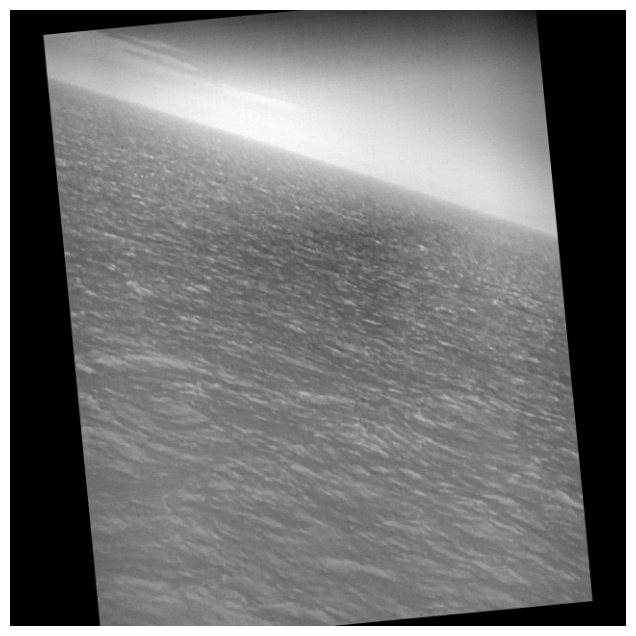

In [7]:
for image, target in dataloader:
    break

print(target)
vis_keypoints(np.array(image[0]), []) # np.array(target).reshape(-1, 2))